In [ ]:
import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
from stable_baselines.common.vec_env import SubprocVecEnv

In [ ]:
def make_env(env_id,rank,seed=101):
  def get_env():
    env=gym.make(env_id)
    env.seed(seed+rank)
    return env
  return get_env

In [ ]:
class Actor(tf.keras.Model):
  def __init__(self,state_size=4,output_size=2):
    super().__init__(self)
    self.lr1=tf.keras.layers.Dense(64,"relu",input_dim=state_size)
    self.lr2=tf.keras.layers.Dense(64,"relu")
    self.lr3=tf.keras.layers.Dense(output_size)

  def call(self,s):
    net=self.lr1(s)
    net=self.lr2(net)
    logits=self.lr3(net)
    return logits

  def action(self,s):
    logits=self.call(s)
    dist=tfp.distributions.Categorical(logits=logits)
    return dist.sample()

  def action_logprobs(self,s,a):
    logits=self.call(s)
    dist=tfp.distributions.Categorical(logits=logits)
    return dist.log_prob(a)

  def entropy(self,s):
    logits=self.call(s)
    dist=tfp.distributions.Categorical(logits=logits)
    return tf.reduce_mean(dist.entropy())

  def actor_loss(self,s,a,adv):
    return -tf.reduce_mean(self.action_logprobs(s,a)*adv)



class Critic(tf.keras.Model):
  def __init__(self,state_size=4):
    super().__init__(self)
    self.lr1=tf.keras.layers.Dense(64,"relu",input_dim=state_size)
    self.lr2=tf.keras.layers.Dense(64,"relu")
    self.lr3=tf.keras.layers.Dense(1)

  def call(self,s):
    net=self.lr1(s)
    net=self.lr2(net)
    value=self.lr3(net)
    return value

  def value(self,s):
    value=self.call(s)
    return value

  def critic_loss(self,s,returns):
    return 0.5*tf.reduce_mean(tf.math.squared_difference(returns,self.value(s)))



In [ ]:
#Helper functions
import functools
import operator

def compute_gae(next_value, rewards, masks, values, gamma=0.99, lam=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * lam * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

def functools_reduce_iconcat(a):
    return np.array(functools.reduce(operator.iconcat, a, []))

def normalize(x):
    x -= x.mean()
    x /= (x.std() + 1e-8)
    return x

In [ ]:
#TESTER
class TESTER:
  def __init__(self,env_id="CartPole-v0"):
    self.test_env=make_env(env_id,10)()

  def test_once(self,actor):
    cs=self.test_env.reset()
    total_reward=0
    done=False
    while not done:
      a=actor.action(cs.reshape(1,-1)).numpy()[0]
      ns,r,done,info=self.test_env.step(a)
      total_reward+=r
      cs=ns
    return total_reward

  def test_avg_score(self,actor,num=10):
    return np.mean([self.test_once(actor) for _ in range(num)])

In [ ]:
#AGENT
actor=Actor()
critic=Critic()
optimizer=tf.keras.optimizers.RMSprop(learning_rate=3e-4)
#ENV
env=SubprocVecEnv([make_env("CartPole-v0",i) for i in range(4)])
tester=TESTER("CartPole-v0")

In [ ]:
scores=[]
for iteration in range(5000):
    states = []
    actions = []
    rewards = []
    values=[]
    masks = []

    curr_states=env.reset()
    for _ in range(256):
        acts=actor.action(curr_states).numpy()
        val=critic.value(curr_states).numpy()
        next_states,rewds,dones,infos=env.step(acts)

        states.append(curr_states)
        actions.append(acts)
        rewards.append(rewds)
        values.append(val.ravel())
        masks.append(1-dones)

        curr_states=next_states
        
    next_val=critic.value(next_states).numpy().ravel()
    
    returns=compute_gae(next_val,rewards,masks,values)

    returns      = functools_reduce_iconcat(returns)
    values       = functools_reduce_iconcat(values)
    states       = functools_reduce_iconcat(states)
    actions      = functools_reduce_iconcat(actions)
    advantage    = returns - values
    advantage    = normalize(advantage)
    returns      = returns.reshape(-1,1)
    
    with tf.GradientTape() as t1:
      actor_loss=actor.actor_loss(states,actions,advantage)
      critic_loss=critic.critic_loss(states,returns)
      entropy=actor.entropy(states)
      loss=actor_loss+0.25*critic_loss-0.01*entropy

    grads=t1.gradient(loss,actor.trainable_variables+critic.trainable_variables)
    optimizer.apply_gradients(zip(grads,actor.trainable_variables+critic.trainable_variables))

    if iteration%10==0:
      score=tester.test_avg_score(actor)
      print("ON ITR {} SCORE {}".format(iteration,score))
      scores.append(score)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

ON ITR 0 SCORE 2

KeyboardInterrupt: 

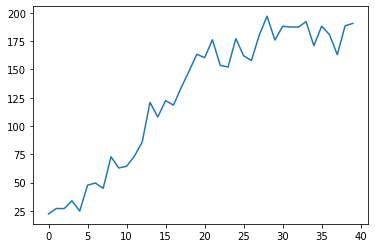

In [ ]:
plt.plot(scores)

In [ ]:
#NICE